<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3155016284.py:27: SyntaxWarning: invalid escape sequence '\s'
  df_train = pd.read_csv('/content/train_FD003.txt', sep='\s+', header=None, names=col_names)
/tmp/ipython-input-3155016284.py:28: SyntaxWarning: invalid escape sequence '\s'
  df_test = pd.read_csv('/content/test_FD003.txt', sep='\s+', header=None, names=col_names)
/tmp/ipython-input-3155016284.py:29: SyntaxWarning: invalid escape sequence '\s'
  y_test = pd.read_csv('/content/RUL_FD003.txt', sep='\s+', header=None, names=['RUL'])


--- Processing Dataset: FD003 ---

--- Training CNN ---


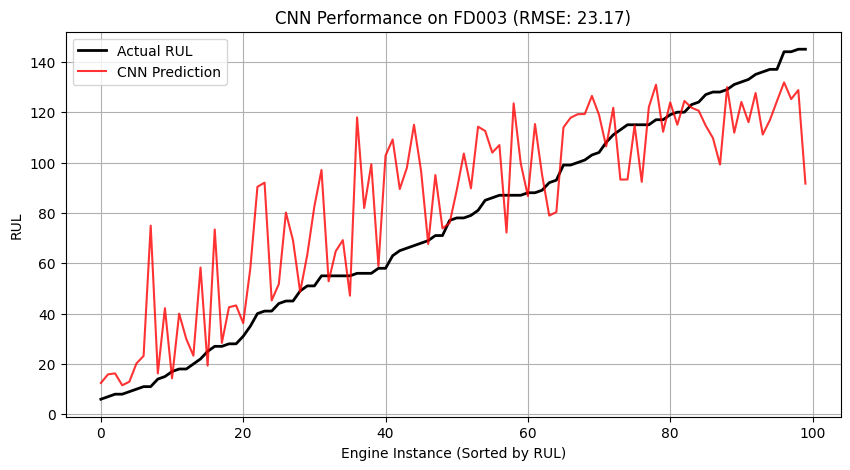


--- Training GRU ---


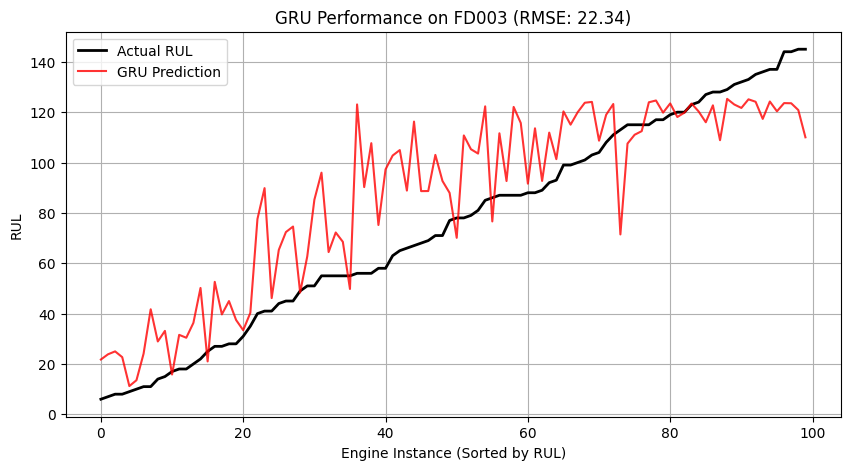


--- Training LSTM ---


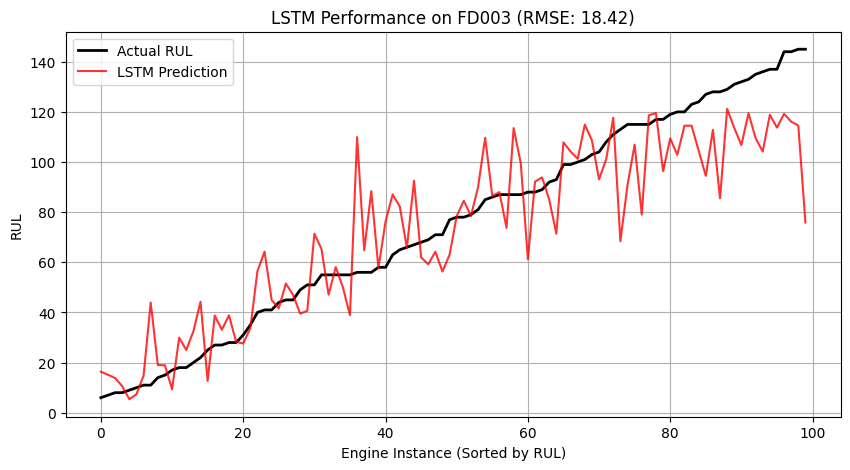


--- Training Stacked_LSTM ---


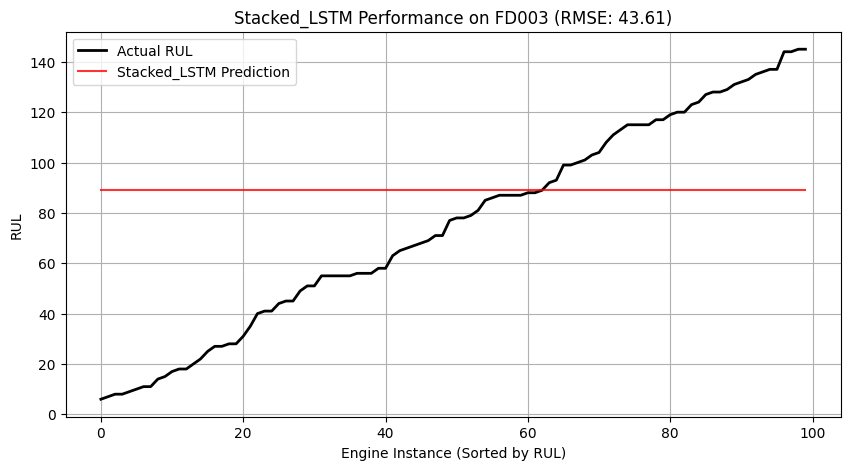


--- Training Bi_LSTM ---


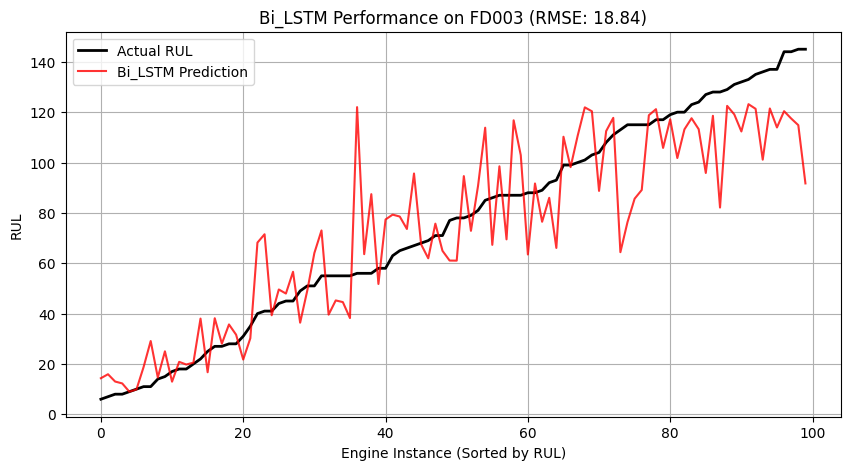


--- Training CNN_LSTM ---


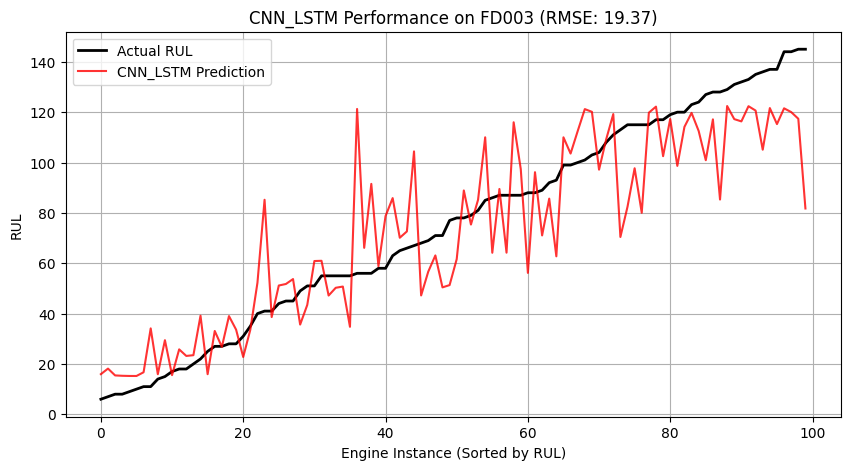


 FINAL PERFORMANCE SUMMARY - FD003
       Model         MSE      RMSE        R2
         CNN  536.792358 23.168780  0.686745
         GRU  499.062317 22.339703  0.708763
        LSTM  339.136902 18.415670  0.802091
Stacked_LSTM 1901.700684 43.608493 -0.109771
     Bi_LSTM  354.906097 18.838952  0.792888
    CNN_LSTM  375.390320 19.374992  0.780934

Best Model: LSTM (Lowest RMSE)
Saving and initiating download for: FD003model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Bidirectional, Flatten, TimeDistributed
from google.colab import files # For downloading to laptop

warnings.filterwarnings('ignore')

# 1. SETUP & DATA LOADING
DATASET_ID = 'FD003'
PATH = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names

print(f"--- Processing Dataset: {DATASET_ID} ---")
df_train = pd.read_csv('/content/train_FD003.txt', sep='\s+', header=None, names=col_names)
df_test = pd.read_csv('/content/test_FD003.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('/content/RUL_FD003.txt', sep='\s+', header=None, names=['RUL'])

# 2. PREPROCESSING FUNCTIONS (WITH PADDING)
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length - 1, -1, -1)
    else:
        return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul - 1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    if len(input_data) < window_length:
        padding_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((padding_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            target_data = np.pad(target_data, (padding_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch, :, :] = input_data[(batch * shift):(batch * shift + window_length), :]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch * shift, batch * shift + window_length
            output_data[batch, :, :] = input_data[start:end, :]
            output_targets[batch] = target_data[end - 1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    if len(test_data_unit) < window_length:
        padding_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((padding_len, 0), (0, 0)), mode='constant')
    max_batches = int(np.floor((len(test_data_unit) - window_length) / shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_data = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_data, num_windows

# 3. FEATURE SELECTION & PREPARATION
# Drop sensors with zero variance (constant values)
drop_cols = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train.drop(columns=['unit_number'] + drop_cols))
test_scaled = scaler.transform(df_test.drop(columns=['unit_number'] + drop_cols))
num_features = train_scaled.shape[1]

window_length, shift, early_rul = 30, 1, 125

# Prepare Training Sequences
X_train_list, Y_train_list = [], []
for unit in df_train['unit_number'].unique():
    unit_data = train_scaled[df_train['unit_number'] == unit]
    unit_target = process_targets(len(unit_data), early_rul)
    x, y = process_input_data_with_targets(unit_data, unit_target, window_length, shift)
    X_train_list.append(x); Y_train_list.append(y)

X_train, Y_train = np.concatenate(X_train_list), np.concatenate(Y_train_list)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Prepare Test Sequences
X_test_list, test_window_counts = [], []
for unit in df_test['unit_number'].unique():
    unit_data = test_scaled[df_test['unit_number'] == unit]
    x, count = process_test_data(unit_data, window_length, shift, num_test_windows=5)
    X_test_list.append(x); test_window_counts.append(count)

X_test_final = np.concatenate(X_test_list)
Y_test_actual = y_test.values.flatten()

# 4. MODEL SPECIFICATIONS
def get_all_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(128, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2, padding='same'),
            layers.Conv1D(128, 3, activation='relu', padding='same'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "GRU": Sequential([
            layers.GRU(128, input_shape=input_shape, return_sequences=True),
            layers.GRU(64),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "Stacked_LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape, return_sequences=True),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "Bi_LSTM": Sequential([
            layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=input_shape),
            layers.Bidirectional(layers.LSTM(64)),
            layers.Dense(96, activation='relu'),
            layers.Dense(1)
        ]),
        "CNN_LSTM": Sequential([
            layers.Conv1D(64, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2),
            layers.LSTM(64),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
    }

# 5. EXECUTION & INDIVIDUAL PLOTTING
models = get_all_models((window_length, num_features))
results_summary = []
sort_idx = np.argsort(Y_test_actual) # For smooth plotting



for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=15, batch_size=256, verbose=0)

    # Prediction logic
    raw_preds = model.predict(X_test_final, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_window_counts)[:-1])
    engine_preds = np.array([np.mean(p) for p in preds_split])

    # Calculate Metrics
    mse = mean_squared_error(Y_test_actual, engine_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_test_actual, engine_preds)
    results_summary.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'Obj': model})

    # INDIVIDUAL PLOT FOR EACH MODEL
    plt.figure(figsize=(10, 5))
    plt.plot(Y_test_actual[sort_idx], color='black', label='Actual RUL', linewidth=2)
    plt.plot(engine_preds[sort_idx], color='red', label=f'{name} Prediction', alpha=0.8)
    plt.title(f"{name} Performance on {DATASET_ID} (RMSE: {rmse:.2f})")
    plt.xlabel("Engine Instance (Sorted by RUL)"); plt.ylabel("RUL")
    plt.legend(); plt.grid(True); plt.show()

# 6. SUMMARY TABLE
df_results = pd.DataFrame(results_summary)
print("\n" + "="*50)
print(f" FINAL PERFORMANCE SUMMARY - {DATASET_ID}")
print("="*50)
print(df_results[['Model', 'MSE', 'RMSE', 'R2']].to_string(index=False))

# 7. EXPORT & DOWNLOAD BEST MODEL
best_model_idx = df_results['RMSE'].idxmin()
best_model_name = df_results.loc[best_model_idx, 'Model']
export_filename = f"{DATASET_ID}model.h5"

# Save the model object
df_results.loc[best_model_idx, 'Obj'].save(export_filename)
print(f"\nBest Model: {best_model_name} (Lowest RMSE)")
print(f"Saving and initiating download for: {export_filename}")

# This triggers the browser download to your laptop
files.download(export_filename)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Bidirectional, Flatten

# 1. SETUP & DATA LOADING
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

# UPDATE PATH FOR FD003
path = '/content/drive/MyDrive/Colab Notebooks/NASA Turbofan Jet Engine Data Set/data/'
df_train = pd.read_csv('/content/train_FD004.txt', sep='\\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv('/content/test_FD004.txt', sep='\\s+', header=None, index_col=False, names=col_names)
y_test = pd.read_csv('/content/RUL_FD003.txt', sep='\\s+', header=None, index_col=False, names=['RUL'])

# 2. PREPROCESSING FUNCTIONS
def process_targets(data_length, early_rul):
    if data_length <= early_rul:
        return np.arange(data_length-1, -1, -1)
    else:
        return np.append(early_rul * np.ones(data_length - early_rul), np.arange(early_rul-1, -1, -1))

def process_input_data_with_targets(input_data, target_data, window_length, shift):
    if len(input_data) < window_length:
        pad_len = window_length - len(input_data)
        input_data = np.pad(input_data, ((pad_len, 0), (0, 0)), mode='constant')
        if target_data is not None:
            target_data = np.pad(target_data, (pad_len, 0), mode='edge')

    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.zeros((num_batches, window_length, num_features))

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(batch*shift):(batch*shift+window_length),:]
        return output_data
    else:
        output_targets = np.zeros(num_batches)
        for batch in range(num_batches):
            start, end = batch*shift, batch*shift+window_length
            output_data[batch,:,:] = input_data[start:end,:]
            output_targets[batch] = target_data[end-1]
        return output_data, output_targets

def process_test_data(test_data_unit, window_length, shift, num_test_windows=5):
    if len(test_data_unit) < window_length:
        pad_len = window_length - len(test_data_unit)
        test_data_unit = np.pad(test_data_unit, ((pad_len, 0), (0, 0)), mode='constant')

    max_batches = int(np.floor((len(test_data_unit) - window_length)/shift)) + 1
    num_windows = min(max_batches, num_test_windows)
    required_len = (num_windows - 1) * shift + window_length
    batched_test = process_input_data_with_targets(test_data_unit[-required_len:, :], None, window_length, shift)
    return batched_test, num_windows

# 3. FEATURE SELECTION & SCALING
# Drop sensors with zero variance (FD003 constant columns)
drop_labels = df_train.columns[df_train.nunique() <= 1].tolist()
scaler = MinMaxScaler()

train_data_scaled = scaler.fit_transform(df_train.drop(columns=['unit_number'] + drop_labels))
test_data_scaled = scaler.transform(df_test.drop(columns=['unit_number'] + drop_labels))

# Save scaler for FD003
joblib.dump(scaler, 'scaler_FD003.pkl')

train_df = pd.DataFrame(np.c_[df_train["unit_number"], train_data_scaled])
test_df = pd.DataFrame(np.c_[df_test["unit_number"], test_data_scaled])

# 4. DATA PREPARATION
window_length, shift, early_rul, num_test_windows = 30, 1, 125, 5
X_train, Y_train = [], []

for i in df_train['unit_number'].unique():
    temp_data = train_df[train_df[0] == i].drop(columns=[0]).values
    temp_targets = process_targets(temp_data.shape[0], early_rul)
    x, y = process_input_data_with_targets(temp_data, temp_targets, window_length, shift)
    X_train.append(x); Y_train.append(y)

X_train, Y_train = np.concatenate(X_train), np.concatenate(Y_train)
X_test, test_windows_list = [], []

for i in df_test['unit_number'].unique():
    temp_data = test_df[test_df[0] == i].drop(columns=[0]).values
    x, num_w = process_test_data(temp_data, window_length, shift, num_test_windows)
    X_test.append(x); test_windows_list.append(num_w)

X_test = np.concatenate(X_test)
Y_test_true = y_test.values.flatten()

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# 5. MODEL ARCHITECTURES
def get_models(input_shape):
    return {
        "CNN": Sequential([
            layers.Conv1D(128, 3, activation='relu', input_shape=input_shape, padding='same'),
            layers.MaxPooling1D(2),
            layers.Conv1D(64, 3, activation='relu', padding='same'),
            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ]),
        "LSTM": Sequential([
            layers.LSTM(128, input_shape=input_shape),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ]),
        "Bi-LSTM": Sequential([
            layers.Bidirectional(layers.LSTM(64), input_shape=input_shape),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
    }

# 6. TRAINING & EVALUATION
models = get_models((window_length, X_train.shape[2]))
history_data = {}
results = []
all_preds = {}



for name, model in models.items():
    print(f"\nTraining {name} on FD003...")
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), verbose=0)
    history_data[name] = history

    # Prediction
    raw_preds = model.predict(X_test, verbose=0).flatten()
    preds_split = np.split(raw_preds, np.cumsum(test_windows_list)[:-1])
    engine_preds = [np.mean(p) for p in preds_split]
    all_preds[name] = engine_preds

    mse = mean_squared_error(Y_test_true, engine_preds)
    results.append({'Model': name, 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2_score(Y_test_true, engine_preds)})

# 7. FINAL VISUALIZATIONS
# Visualization 1: Loss History
plt.figure(figsize=(15, 5))
for i, (name, history) in enumerate(history_data.items()):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{name} Loss History')
    plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend()
plt.tight_layout(); plt.show()

# Visualization 2: Actual vs Predicted RUL
sort_idx = np.argsort(Y_test_true)
plt.figure(figsize=(12, 6))
plt.plot(Y_test_true[sort_idx], color='black', label='Actual RUL', linewidth=2)
for name, preds in all_preds.items():
    plt.plot(np.array(preds)[sort_idx], label=f'{name} Pred', alpha=0.7)
plt.title('FD003: Actual vs Predicted RUL (Sorted)')
plt.xlabel('Engine Instances'); plt.ylabel('Cycles'); plt.legend(); plt.show()

# Final Metrics Table
res_df = pd.DataFrame(results)
print("\nFinal Performance Summary for FD003:")
print(res_df.to_string(index=False))


Training CNN on FD003...


ValueError: Found input variables with inconsistent numbers of samples: [100, 248]